In [1]:
import os
import sys
import pandas as pd
import glob
import torch
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("../"))

In [2]:
import os
from data_generation.aircraft_data_generator import Aircraft , Fleet
from federated.centralized_server import CentralizedServer, FederatedClient


In [ ]:
import shutil

data_path = os.path.join("..", "data")
if os.path.exists(data_path):
    for item in os.listdir(data_path):
        item_path = os.path.join(data_path, item)
        if os.path.isfile(item_path) or os.path.islink(item_path): ### 
            os.remove(item_path)
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)

In [4]:
# Création d'une flotte de 5 avions, avec 1 avion contenant une anomalie
fleet = Fleet(
    fleet_id=1,
    num_aircraft=5,
    num_anomalous=1,         
    num_points=200,
    interval_minutes=5,
    anomaly_duration=200,
    anomaly_features=["engine_rpm", "fuel_flow", "engine_temperature"]
)

fleet.generate_fleet_data()

📁 Dataset saved as ../data/aircraft_data\fleet_1\aircraft_1_1_normal.csv
🛩️ Aircraft 1-1 generated (Normal)
📁 Dataset saved as ../data/aircraft_data\fleet_1\aircraft_1_2_normal.csv
🛩️ Aircraft 1-2 generated (Normal)
📁 Dataset saved as ../data/aircraft_data\fleet_1\aircraft_1_3_normal.csv
🛩️ Aircraft 1-3 generated (Normal)
📁 Dataset saved as ../data/aircraft_data\fleet_1\aircraft_1_4_normal.csv
🛩️ Aircraft 1-4 generated (Normal)
✅ Anomaly 'fuel_leak' on ['engine_rpm', 'fuel_flow', 'engine_temperature'] from 2025-01-01 00:00:00 to 2025-01-01 16:35:00 on aircraft 1-5
📁 Dataset saved as ../data/aircraft_data\fleet_1\aircraft_1_5_anomalous.csv
🛩️ Aircraft 1-5 generated (Anomalous)
📝 Anomaly summary saved for fleet 1


In [15]:
# Liste des fichiers générés pour cette flotte
csv_files = glob.glob("../data/aircraft_data/fleet_1/aircraft_*.csv")
csv_files.sort()

print("Fichiers détectés :")
for file in csv_files:
    print(file)


Fichiers détectés :
../data/aircraft_data/fleet_1\aircraft_1_1_normal.csv
../data/aircraft_data/fleet_1\aircraft_1_2_normal.csv
../data/aircraft_data/fleet_1\aircraft_1_3_normal.csv
../data/aircraft_data/fleet_1\aircraft_1_4_normal.csv
../data/aircraft_data/fleet_1\aircraft_1_5_anomalous.csv


In [16]:
# Chaque client est un avion avec son fichier CSV
clients = []

for idx, path in enumerate(csv_files):
    clients.append(FederatedClient(client_id=idx, file_paths=[path]))

print(f"{len(clients)} clients créés.")


5 clients créés.


In [17]:
# Serveur fédéré avec tous les clients
server = CentralizedServer(clients)


In [18]:
# Entraînement FL avec FedAvg
server.train(
    rounds=10,           # Nombre de rounds fédérés
    local_epochs=100,     # Nombre d'époques locales par client
    lr=1e-3            # Taux d'apprentissage
)



📡 ROUND 1/10
Client 0 - Entraînement local...
Epoch [1/100] - Loss: 0.2435
Epoch [2/100] - Loss: 0.2194
Epoch [3/100] - Loss: 0.1947
Epoch [4/100] - Loss: 0.1706
Epoch [5/100] - Loss: 0.1471
Epoch [6/100] - Loss: 0.1246
Epoch [7/100] - Loss: 0.1032
Epoch [8/100] - Loss: 0.0835
Epoch [9/100] - Loss: 0.0662
Epoch [10/100] - Loss: 0.0527
Epoch [11/100] - Loss: 0.0435
Epoch [12/100] - Loss: 0.0386
Epoch [13/100] - Loss: 0.0378
Epoch [14/100] - Loss: 0.0380
Epoch [15/100] - Loss: 0.0380
Epoch [16/100] - Loss: 0.0374
Epoch [17/100] - Loss: 0.0367
Epoch [18/100] - Loss: 0.0362
Epoch [19/100] - Loss: 0.0361
Epoch [20/100] - Loss: 0.0361
Epoch [21/100] - Loss: 0.0360
Epoch [22/100] - Loss: 0.0359
Epoch [23/100] - Loss: 0.0357
Epoch [24/100] - Loss: 0.0357
Epoch [25/100] - Loss: 0.0356
Epoch [26/100] - Loss: 0.0355
Epoch [27/100] - Loss: 0.0354
Epoch [28/100] - Loss: 0.0353
Epoch [29/100] - Loss: 0.0352
Epoch [30/100] - Loss: 0.0351
Epoch [31/100] - Loss: 0.0350
Epoch [32/100] - Loss: 0.0350
Ep

In [19]:

from IPython.display import display

bench = server.benchmark_all_clients()
display(bench)              


,client_id,mean_mse,max_mse,std_mse,n_points
0,1,0.024007,0.135074,0.023106,100
1,4,0.022412,0.161513,0.024377,100
2,2,0.020123,0.103886,0.019777,100
3,3,0.020119,0.089961,0.018289,100
4,0,0.016384,0.085947,0.013829,100


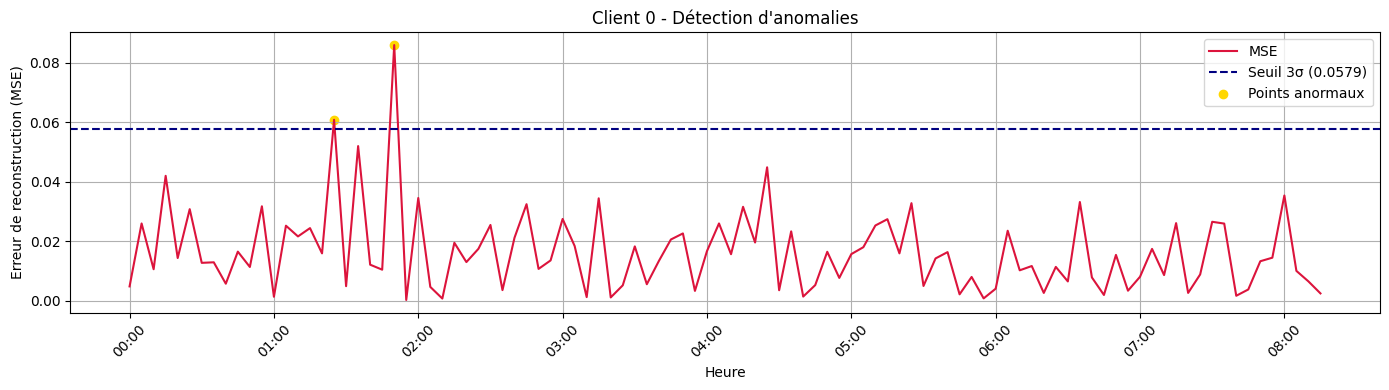

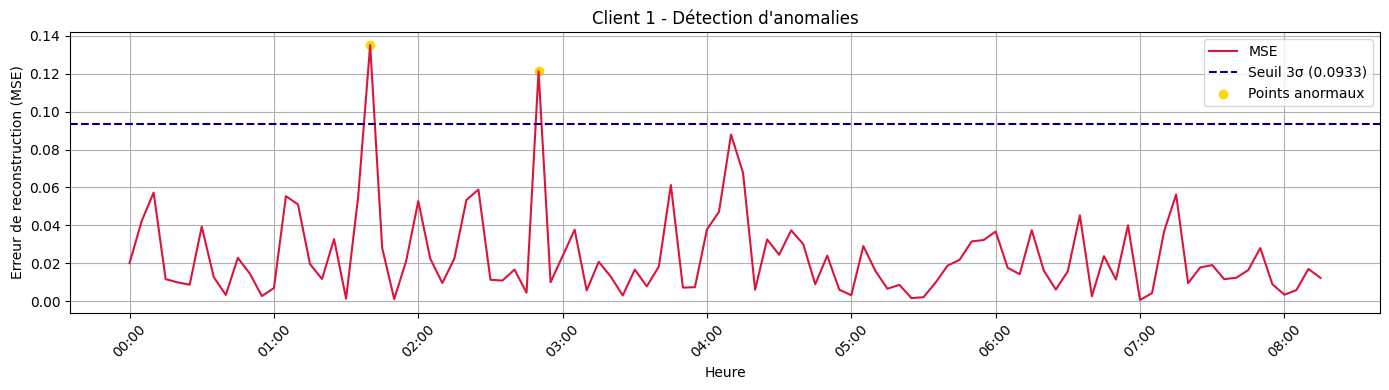

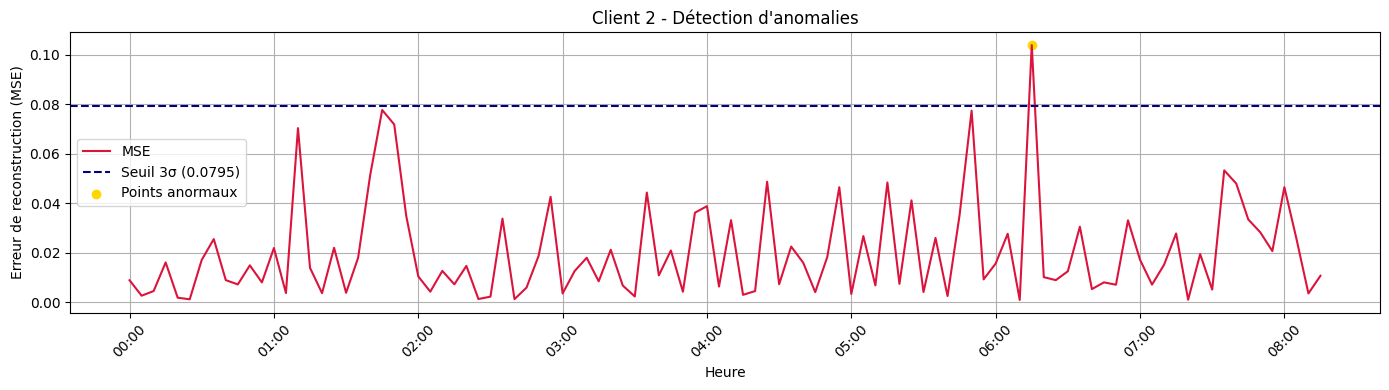

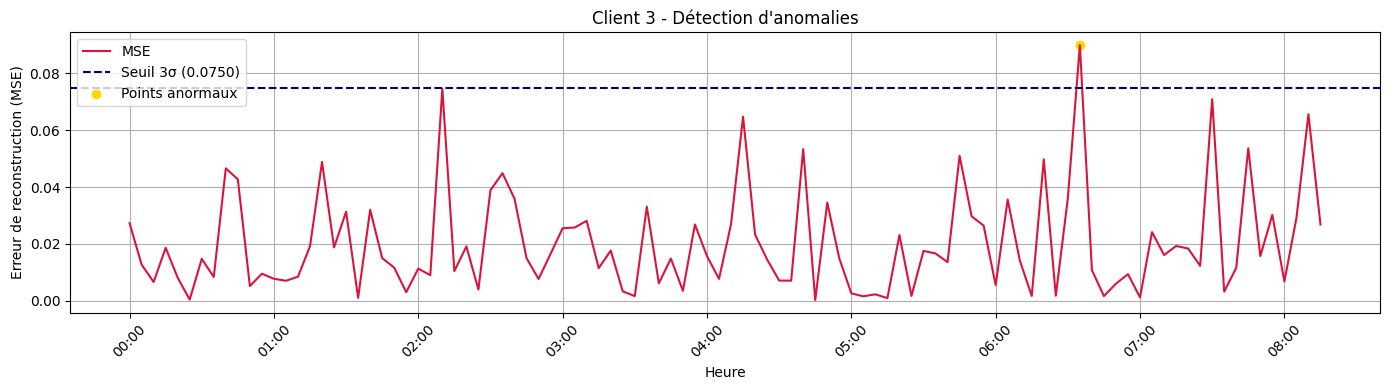

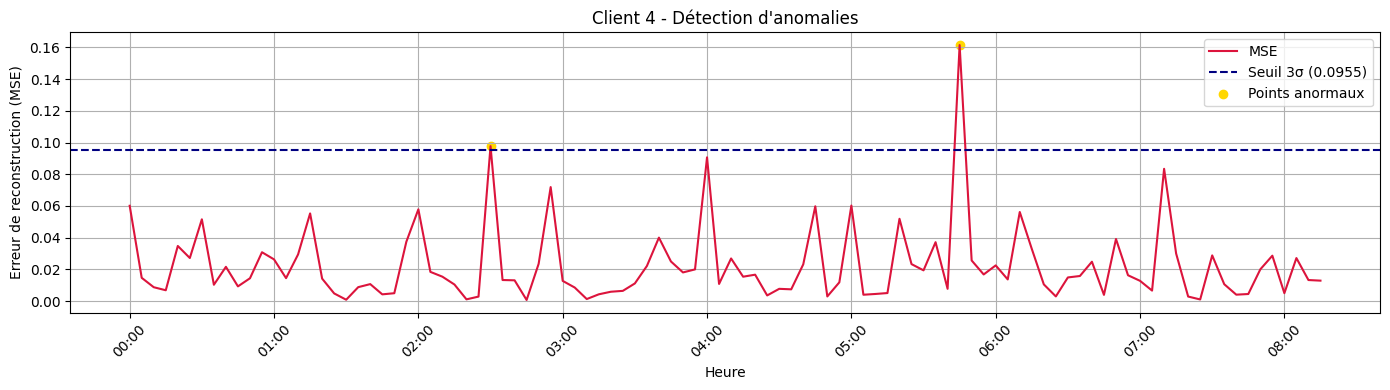

In [ ]:

import matplotlib.dates as mdates


for client_id, client in enumerate(server.clients):
    csv_path = client.file_paths[0]
    df = pd.read_csv(csv_path)
    timestamps = pd.to_datetime(df['timestamp'])

    errs, th, _ = server.evaluate_client(client_id)

    plt.figure(figsize=(14, 4))
    plt.plot(timestamps, errs, label='MSE', color='crimson')
    plt.axhline(th, color='navy', linestyle='--', label=f'Seuil 3σ ({th:.4f})')
    plt.scatter(timestamps[errs > th], errs[errs > th], color='gold', label='Points anormaux')

    # Afficher uniquement les heures (pas la date)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # tick chaque heure
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # format heure uniquement

    plt.title(f"Client {client_id} - Détection d'anomalies")
    plt.xlabel("Heure")
    plt.ylabel("Erreur de reconstruction (MSE)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()     ####### RMSE au lieu du MSE
    plt.show()